In [5]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


Epoch 1/1000


c:\Users\k47r1\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 1s - 79ms/step - loss: 5.5585e-04 - val_loss: 3.7291e-04
Epoch 2/1000
13/13 - 0s - 7ms/step - loss: 4.0022e-04 - val_loss: 3.5646e-04
Epoch 3/1000
13/13 - 0s - 7ms/step - loss: 3.4729e-04 - val_loss: 3.5604e-04
Epoch 4/1000
13/13 - 0s - 6ms/step - loss: 3.0395e-04 - val_loss: 3.5742e-04
Epoch 5/1000
13/13 - 0s - 7ms/step - loss: 2.6572e-04 - val_loss: 3.5574e-04
Epoch 6/1000
13/13 - 0s - 6ms/step - loss: 2.2946e-04 - val_loss: 3.6110e-04
Epoch 6: early stopping
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Score (RMSE): 0.018861033022403717


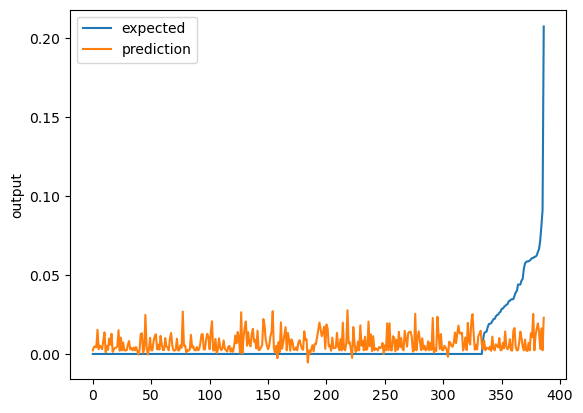

In [13]:
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

path = "./yelp_dataset/"
preprocess = True

review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

#You may use the following code to convert JSON data into a tabular format Pandas can read.
review_df = pd.read_json(review_Path, lines=True, nrows = 10000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 10000)
business_df = all_business_df[all_business_df['review_count'] >= 20]
business_df = business_df.dropna()
review_df = review_df.dropna()

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table
#business_col = ['business_id', 'stars']
#review_col = ['business_id', 'all_reviews']
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
#print(merged_df)


# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit and transform the aggregated reviews
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Convert the result into a DataFrame for better readability 
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
x,y = to_xy(tfidf_df,'stars')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1, activation='linear'))

adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer='adam')


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)


